In [2]:
import os
from pathlib import Path
import sqlite3
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import polyline as ppl
from pyproj import Geod
import folium
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)

In [3]:
# data directory and files

data_dir = Path.cwd().parents[1] / "data"
wzdx_data_file = data_dir / "az511.db"
inrix_data_dir = data_dir/ "INRIX data"
inrix_data_1 = inrix_data_dir / "I10-and-I17-1year" / "I10-and-I17-1year.csv"
inrix_data_2 = inrix_data_dir / "Loop101-1year" / "Loop101-1year.csv"
inrix_data_3 = inrix_data_dir / "SR60-1year" / "SR60-1year.csv"


In [4]:
# Defining methods to get data
# The name of the table in wzdx is events. Since this table is small, it can be loaded into the pandas dataframe directly w/o using too much memory.

def data_wzdx(data_file):
    con = sqlite3.connect(data_file)
    cur = con.cursor()

    cur.execute("SELECT * FROM events")
    columns = [desc[0] for desc in cur.description]

    data_df = pd.DataFrame(cur.fetchall(), columns=columns)

    con.close()

    return data_df

def data_inrix(data_file, n=1000):
    data = pd.read_csv(data_file, nrows=n)
    return data

In [5]:
df = data_wzdx(wzdx_data_file)

def line_from_encoded(enc):
    if pd.isna(enc) or enc == '':
        return None
    coords_latlon = ppl.decode(enc)
    coords_lonlat = [(lon, lat) for (lat, lon) in coords_latlon]
    return LineString(coords_lonlat)

In [6]:
df.loc[df['Longitude'].isnull()]
df.loc[df['Latitude'].isnull()]

,ID,Organization,RoadwayName,DirectionOfTravel,Description,Reported,LastUpdated,StartDate,PlannedEndDate,LanesAffected,Latitude,Longitude,LatitudeSecondary,LongitudeSecondary,EventType,EventSubType,IsFullClosure,Severity,EncodedPolyline,Width,Height,Length,Weight,Speed,DetourPolyline,DetourInstructions,Recurrence,RecurrenceSchedules,Details,LaneCount
14649,458580,Tucson,USE CAUTION: FLOODING MANVILL ALL DIRECTIONS,None,USE CAUTION: FLOODING MANVILL ALL DIRECTIONS...,1752669174,1753199920,1752669174,NaN,No Data,NaN,NaN,NaN,NaN,accidentsAndIncidents,None,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN
25593,482178,Tucson,ROAD CLOSED: MANN AVE & DREXEL RD WESTBOUND,None,ROAD CLOSED: MANN AVE & DREXEL RD WESTBOUND...,1755648142,1755716292,1755648142,NaN,No Data,NaN,NaN,NaN,NaN,accidentsAndIncidents,None,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN
25594,482181,Tucson,ROAD CLOSED: DREXEL RD & WILMOT RD EASTBOUND,None,ROAD CLOSED: DREXEL RD & WILMOT RD EASTBOUND...,1755648437,1755716292,1755648437,NaN,No Data,NaN,NaN,NaN,NaN,accidentsAndIncidents,None,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN


There are only 3 rows in WZDx data with no Latitude or Longitude. It is better to impute them.

In [7]:
df = df.loc[~df['Longitude'].isnull()]

Check for empty rows after imputing

In [8]:
df.loc[df['Longitude'].isnull()]
df.loc[df['Latitude'].isnull()]

,ID,Organization,RoadwayName,DirectionOfTravel,Description,Reported,LastUpdated,StartDate,PlannedEndDate,LanesAffected,Latitude,Longitude,LatitudeSecondary,LongitudeSecondary,EventType,EventSubType,IsFullClosure,Severity,EncodedPolyline,Width,Height,Length,Weight,Speed,DetourPolyline,DetourInstructions,Recurrence,RecurrenceSchedules,Details,LaneCount


In [9]:
time_columns = ['Reported', 'LastUpdated', 'StartDate', 'PlannedEndDate']

for col in time_columns:
    df['Local' + col] = df[col]%10000000000
    df['Local' + col] = pd.to_datetime(df['Local' + col], unit='s', utc=True).dt.tz_convert("America/Phoenix").dt.strftime("%Y-%m-%d %H:%M:%S")


In [10]:
df.sample(5)

,ID,Organization,RoadwayName,DirectionOfTravel,Description,Reported,LastUpdated,StartDate,PlannedEndDate,LanesAffected,Latitude,Longitude,LatitudeSecondary,LongitudeSecondary,EventType,EventSubType,IsFullClosure,Severity,EncodedPolyline,Width,Height,Length,Weight,Speed,DetourPolyline,DetourInstructions,Recurrence,RecurrenceSchedules,Details,LaneCount,LocalReported,LocalLastUpdated,LocalStartDate,LocalPlannedEndDate
482,374990,RADS,Germann Rd,None,Germann Rd - road construction - WB BLC & SWC,1747612800,1748897888,1747612800,1.749773e+09,No Data,33.276674,-111.848524,NaN,NaN,roadwork,road construction,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,2025-05-18 17:00:00,2025-06-02 13:58:08,2025-05-18 17:00:00,2025-06-12 17:00:00
23829,479782,RADS,LINDSAY RD MESA,None,1916 S LINDSAY RD MESA - AccidentIncident - ga...,1755513614,1755521943,1755513614,3.565934e+10,No Data,33.380330,-111.772488,NaN,NaN,accidentsAndIncidents,AccidentIncident,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,2025-08-18 03:40:14,2025-08-18 05:59:03,2025-08-18 03:40:14,2149-05-03 06:39:59
26412,483731,RADS,E INDIAN SCHOOL RD / N PIMA RD,None,E INDIAN SCHOOL RD / N PIMA RD - road construc...,1754312400,1755921552,1754312400,1.756163e+09,No Data,33.494860,-111.891322,NaN,NaN,roadwork,road construction,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,2025-08-04 06:00:00,2025-08-22 20:59:12,2025-08-04 06:00:00,2025-08-25 16:00:00
45589,533496,RADS,32ND ST,None,"32ND ST - road construction - BO, TR, AS, CC",1757314800,1759345154,1757314800,1.760080e+09,No Data,33.604262,-112.013211,NaN,NaN,roadwork,road construction,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,2025-09-08 00:00:00,2025-10-01 11:59:14,2025-09-08 00:00:00,2025-10-10 00:00:00
11963,446331,RADS,GARFIELD ST,None,GARFIELD ST - road construction - rane operati...,1753210800,1752800290,1753210800,1.753254e+09,No Data,33.457619,-112.068718,NaN,NaN,roadwork,road construction,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,2025-07-22 12:00:00,2025-07-17 17:58:10,2025-07-22 12:00:00,2025-07-22 23:59:00


In [11]:
geom = []

Imputing Tucson data. About 7k out of 37k rows (~19%)

In [12]:
min_lat, max_lat = 33.05, 33.85
min_lon, max_lon = -112.72,-111.45

geo_mask = df["Latitude"].between(min_lat, max_lat) & df["Longitude"].between(min_lon, max_lon)
df_in = df.loc[geo_mask]

df_in.shape

(38067, 34)

In [13]:

# df = df.loc[14410:14414]
for _, r in df_in.iterrows():
    ln = line_from_encoded(r.get('EncodedPolyline'))
    if ln is not None:
        geom.append(ln)
    else:
        if pd.notna(r['Longitude']) and pd.notna(r['Latitude']):
            geom.append(Point(r['Longitude'], r['Latitude']))
        else:
            geom.append(None)


In [14]:
gdf = gpd.GeoDataFrame(df_in, geometry=geom, crs='EPSG:4326')

light_props = [
    'ID','RoadwayName','DirectionOfTravel','EventType','EventSubType',
    'IsFullClosure','Severity', 'LocalReported', 'LocalStartDate','LocalPlannedEndDate','LanesAffected','LaneCount',
    'geometry'
]
gdf_map = gdf[light_props]

gdf_map


,ID,RoadwayName,DirectionOfTravel,EventType,EventSubType,IsFullClosure,Severity,LocalReported,LocalStartDate,LocalPlannedEndDate,LanesAffected,LaneCount,geometry
0,361395,US-60,West,roadwork,turninglaneclosed,0,Minor,2025-05-02 21:00:00,2025-05-02 21:00:00,2025-06-13 05:00:00,No Data,3.0,"LINESTRING (-112.3571 33.64406, -112.35719 33...."
1,378561,4TH AVE,None,roadwork,road construction,0,None,2025-03-31 00:00:00,2025-03-31 00:00:00,2025-06-13 00:00:00,No Data,NaN,POINT (-112.07893 33.4567)
2,378562,3RD AVE,None,roadwork,road construction,0,None,2025-03-31 00:00:00,2025-03-31 00:00:00,2025-06-13 00:00:00,No Data,NaN,POINT (-112.07769 33.45669)
3,378620,24TH ST,None,roadwork,road construction,0,None,2025-04-28 21:00:00,2025-04-28 21:00:00,2025-06-13 05:00:00,No Data,NaN,POINT (-112.03438 33.44106)
4,378642,INDIAN SCHOOL RD,None,roadwork,road construction,0,None,2025-05-06 00:00:00,2025-05-06 00:00:00,2025-06-13 00:00:00,No Data,NaN,POINT (-112.05633 33.49472)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46481,535432,I-10,West,accidentsAndIncidents,crashRlane,0,Minor,2025-10-01 11:46:00,2025-10-01 11:46:00,NaN,No Data,1.0,POINT (-112.07695 33.46183)
46483,535434,"MCDOWELL RD ,GDY",None,accidentsAndIncidents,AccidentIncident,0,None,2025-10-01 11:53:02,2025-10-01 11:53:02,2149-05-03 06:39:59,No Data,NaN,POINT (-112.39328 33.46463)
46484,535435,S RURAL RD / E SPENCE AVE ...,None,accidentsAndIncidents,AccidentIncident,0,None,2025-10-01 11:49:39,2025-10-01 11:49:39,2149-05-03 06:39:59,No Data,NaN,POINT (-111.92628 33.41287)
46485,535436,S Gilbert Rd,South,roadwork,pavingOperations,0,Minor,2025-10-04 17:00:00,2025-10-04 17:00:00,2025-10-05 18:00:00,No Data,3.0,"LINESTRING (-111.78977 33.28611, -111.78977 33..."


In [15]:
gdf_preview = gdf_map.sample(1000)

m = folium.Map(location=[33.4484, -112.0740], zoom_start=11)
folium.GeoJson(
    gdf_preview,
    name="WZDx (preview)",
    tooltip=folium.GeoJsonTooltip(fields=[f for f in ['RoadwayName','EventType', 'LocalReported', 'LocalStartDate', 'LocalPlannedEndDate']])
).add_to(m)
folium.LayerControl().add_to(m)
m.save("events.html")

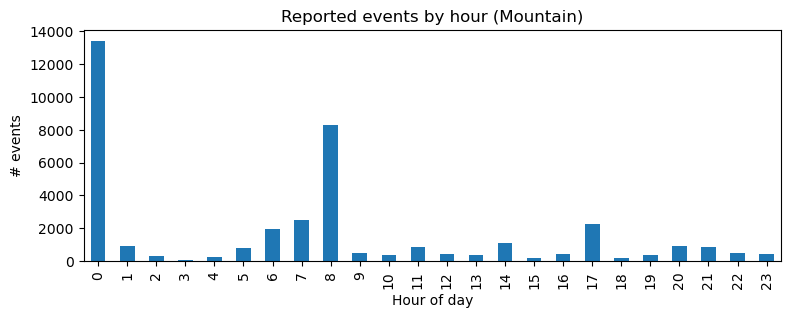

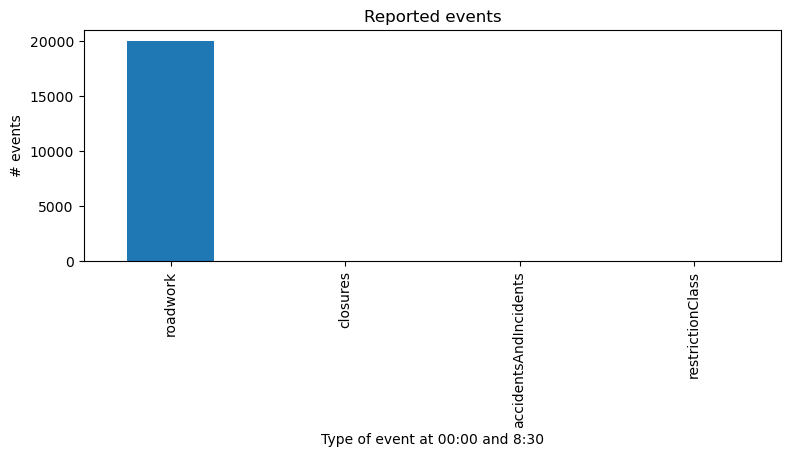

In [17]:
from datetime import time
reportedDT = pd.to_datetime(df_in['LocalReported'])
by_hour = reportedDT.dt.hour.value_counts().sort_index()

ax = by_hour.plot(kind='bar', figsize=(9,3))
ax.set_xlabel('Hour of day'); ax.set_ylabel('# events'); ax.set_title('Reported events by hour (Mountain)')
plt.show()



mask_time = reportedDT.dt.time.isin([time(0,0), time(8,30)])


ax = df_in.loc[mask_time, 'EventType'].value_counts().plot(kind='bar', figsize=(9,3))
ax.set_xlabel('Type of event at 00:00 and 8:30'); ax.set_ylabel('# events'); ax.set_title('Reported events')
plt.show()






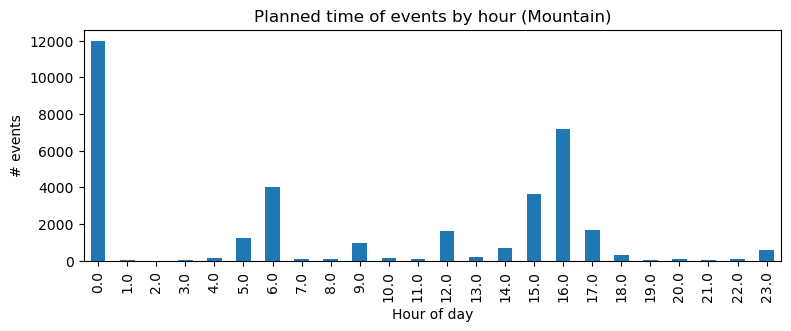

In [154]:
reportedDT = pd.to_datetime(df['LocalPlannedEndDate'])
by_hour = reportedDT.dt.hour.value_counts().sort_index()

ax = by_hour.plot(kind='bar', figsize=(9,3))
ax.set_xlabel('Hour of day'); ax.set_ylabel('# events'); ax.set_title('Planned time of events by hour (Mountain)')
plt.show()

In [155]:
# dfImputed = df_in.loc[~mask_time]
dfImputed = df_in.loc[df_in['EventType'].isin(['accidentsAndIncidents'])]
# dfComplementImputed = df_in.loc[mask_time]
dfImputed.shape

(8539, 34)

In [158]:
df_in.loc[df_in['EventType']=='accidentsAndIncidents', 'EventSubType'].value_counts()

EventSubType
AccidentIncident           3661
Crash on right shoulder     879
C34Rshoulder                801
DebrisRshoulder             275
C34Lshoulder                197
                           ... 
TBIB                          1
C34centerLanes                1
amberAlert                    1
T1018EXB                      1
leftlanes                     1
Name: count, Length: 114, dtype: int64

In [157]:
df['EventType'].value_counts()

EventType
roadwork                 30397
accidentsAndIncidents    15060
closures                   876
specialEvents              135
restrictionClass            17
Name: count, dtype: int64

In [129]:
df_in.loc[mask_time].sample(5)

,ID,Organization,RoadwayName,DirectionOfTravel,Description,Reported,LastUpdated,StartDate,PlannedEndDate,LanesAffected,Latitude,Longitude,LatitudeSecondary,LongitudeSecondary,EventType,EventSubType,IsFullClosure,Severity,EncodedPolyline,Width,Height,Length,Weight,Speed,DetourPolyline,DetourInstructions,Recurrence,RecurrenceSchedules,Details,LaneCount,LocalReported,LocalLastUpdated,LocalStartDate,LocalPlannedEndDate
38996,507640,Glendale,51ST AVE AND LAMAR,northbound,NORTH BOUND RIGHT LANE CLOSURE,1757919600,1757741472,1757919600,1.758352e+09,some-lanes-closed,33.535442,-112.168537,NaN,NaN,roadwork,ROAD_CLOSED_CONSTRUCTION,0,None,o{tkEj|rkTuFACC@kC,None,None,None,None,None,None,None,None,None,None,NaN,2025-09-15 00:00:00,2025-09-12 22:31:12,2025-09-15 00:00:00,2025-09-20 00:00:00
1349,430414,RADS,E JOMAX RD / N SCOTTSDALE RD,None,E JOMAX RD / N SCOTTSDALE RD - road constructi...,1745478000,1750219152,1745478000,1.757056e+09,No Data,33.734548,-111.925916,NaN,NaN,roadwork,road construction,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,2025-04-24 00:00:00,2025-06-17 20:59:12,2025-04-24 00:00:00,2025-09-05 00:00:00
14879,461487,RADS,44TH ST,None,44TH ST - road construction - SE,1738825200,1753264744,1738825200,1.754032e+09,No Data,33.485970,-111.986967,NaN,NaN,roadwork,road construction,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,2025-02-06 00:00:00,2025-07-23 02:59:04,2025-02-06 00:00:00,2025-08-01 00:00:00
38827,498987,RADS,Jackson Ave,None,Jackson Ave - road construction - Bore,1756913400,1758319141,1756913400,1.758323e+09,No Data,33.369297,-112.586032,NaN,NaN,roadwork,road construction,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,2025-09-03 08:30:00,2025-09-19 14:59:01,2025-09-03 08:30:00,2025-09-19 16:00:00
32554,500426,RADS,LAFAYETTE BLVD,None,LAFAYETTE BLVD - road construction - TR/BO/AS/CC,1755759600,1756893546,1755759600,1.756969e+09,No Data,33.494577,-111.956823,NaN,NaN,roadwork,road construction,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,2025-08-21 00:00:00,2025-09-03 02:59:06,2025-08-21 00:00:00,2025-09-04 00:00:00


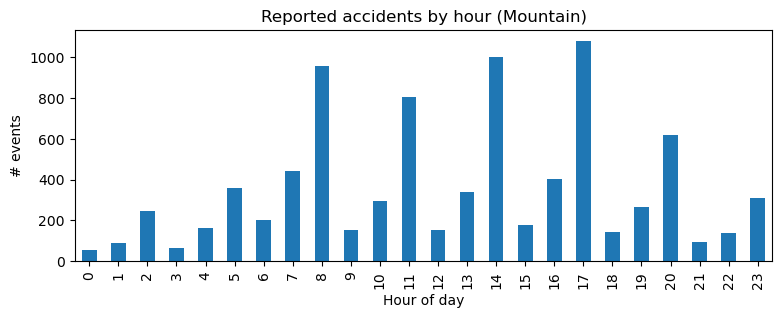

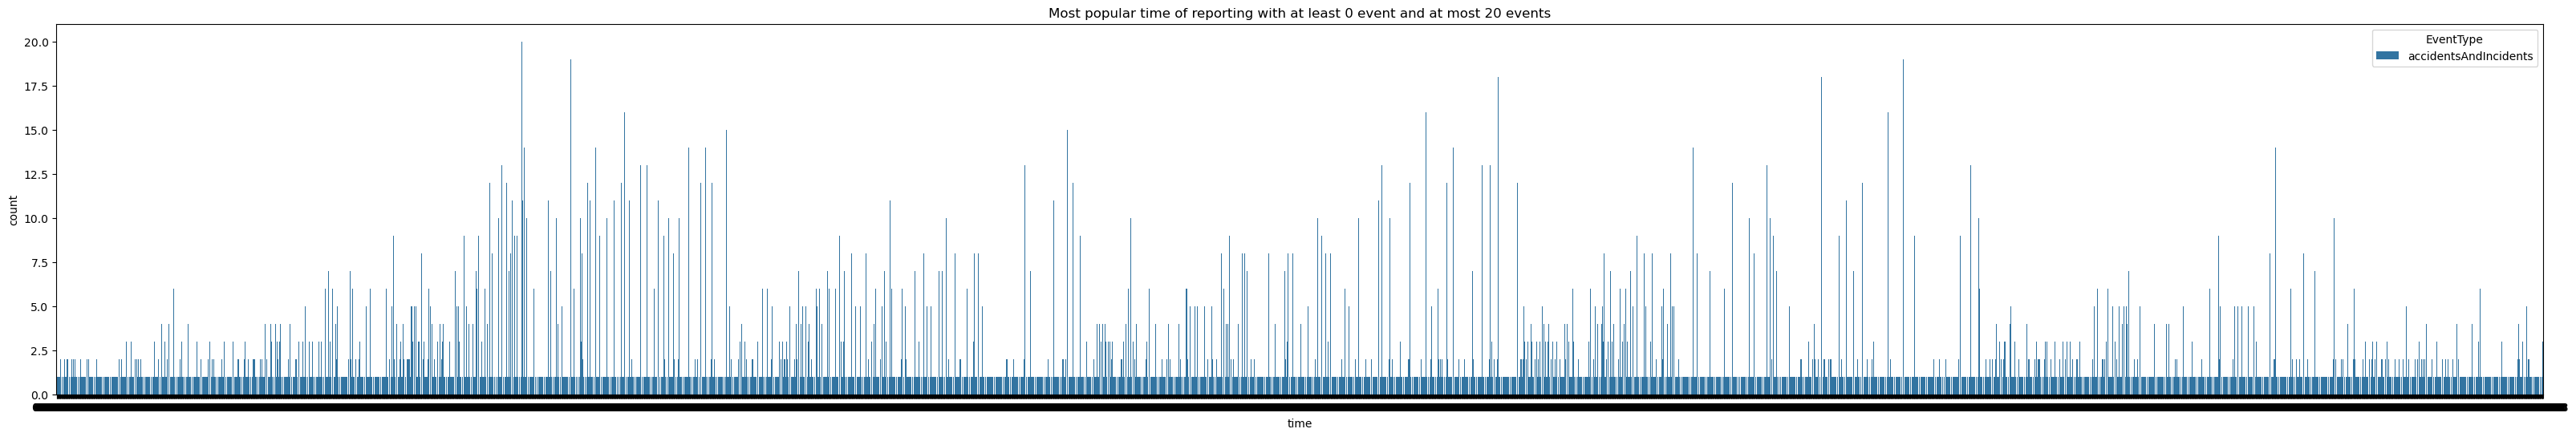

LocalReported
08:00:00    20
17:48:00    19
08:20:00    19
17:37:00    18
14:54:00    18
            ..
10:31:58     1
11:36:28     1
11:53:02     1
11:49:39     1
11:54:25     1
Name: count, Length: 4498, dtype: int64

In [130]:
from datetime import date, time
reportedDT = pd.to_datetime(dfImputed['LocalReported'])
by_hour = reportedDT.dt.hour.value_counts().sort_index()

ax = by_hour.plot(kind='bar', figsize=(9,3))
ax.set_xlabel('Hour of day'); ax.set_ylabel('# events'); ax.set_title('Reported accidents by hour (Mountain)')
plt.show()

by_time = reportedDT.dt.time.value_counts()
max_time_count = max(by_time)
min_time_count = 0

df_time_binned = dfImputed.loc[reportedDT.dt.time.isin(by_time.loc[(by_time>min_time_count) & (by_time <= max_time_count)].index.to_list()), ['EventType', 'LocalReported']]

df_time_binned['time'] = pd.to_datetime(df_time_binned['LocalReported']).dt.time
df_time_binned = df_time_binned.sort_values('time')

fig, ax = plt.subplots(figsize=(40, 6))

sns.countplot(df_time_binned, x='time', hue='EventType', ax=ax, stat='count')
ax.set_title("Most popular time of reporting with at least " + str(min_time_count)+ " event and at most " + str(max_time_count) + " events")
plt.show()
by_time

In [131]:
dfImputed.loc[reportedDT.dt.time.isin(by_time.loc[by_time > 5].index.to_list()) & dfImputed['Severity'].isin(['Major']) & dfImputed['EventType'].isin(['accidentsAndIncidents']) & reportedDT.dt.date.isin([date(2025, 8, 29)])]

,ID,Organization,RoadwayName,DirectionOfTravel,Description,Reported,LastUpdated,StartDate,PlannedEndDate,LanesAffected,Latitude,Longitude,LatitudeSecondary,LongitudeSecondary,EventType,EventSubType,IsFullClosure,Severity,EncodedPolyline,Width,Height,Length,Weight,Speed,DetourPolyline,DetourInstructions,Recurrence,RecurrenceSchedules,Details,LaneCount,LocalReported,LocalLastUpdated,LocalStartDate,LocalPlannedEndDate


In [132]:
dfImputed.loc[reportedDT.dt.date.isin([date(2025, 8, 29)])].sort_values('LocalReported')

,ID,Organization,RoadwayName,DirectionOfTravel,Description,Reported,LastUpdated,StartDate,PlannedEndDate,LanesAffected,Latitude,Longitude,LatitudeSecondary,LongitudeSecondary,EventType,EventSubType,IsFullClosure,Severity,EncodedPolyline,Width,Height,Length,Weight,Speed,DetourPolyline,DetourInstructions,Recurrence,RecurrenceSchedules,Details,LaneCount,LocalReported,LocalLastUpdated,LocalStartDate,LocalPlannedEndDate
28786,496192,RADS,CRISMON RD MESA,None,1911 S CRISMON RD MESA - AccidentIncident - ac...,1756453362,1756461549,1756453362,3.565934e+10,No Data,33.380669,-111.618457,NaN,NaN,accidentsAndIncidents,AccidentIncident,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,2025-08-29 00:42:42,2025-08-29 02:59:09,2025-08-29 00:42:42,2149-05-03 06:39:59
28789,496203,ERS,I-17,South,Crash on I-17 Southbound near 101-LOOP East...,1756459920,1756460000,1756459920,NaN,No Data,33.662242,-112.114061,NaN,NaN,accidentsAndIncidents,accident,0,Minor,None,None,None,None,None,None,None,None,None,None,None,1.0,2025-08-29 02:32:00,2025-08-29 02:33:20,2025-08-29 02:32:00,NaN
29593,496214,ERS,US-60,East,Crash on the left shoulder on US-60 Eastbound ...,1756465740,1756465828,1756465740,NaN,No Data,33.386150,-111.781501,NaN,NaN,accidentsAndIncidents,CrashLshoulder,0,Minor,None,None,None,None,None,None,None,None,None,None,None,1.0,2025-08-29 04:09:00,2025-08-29 04:10:28,2025-08-29 04:09:00,NaN
29594,496216,ERS,I-10,East,Crash blocking the on ramp on I-10 Eastbound ...,1756467120,1756467144,1756467120,NaN,No Data,33.384481,-111.967947,NaN,NaN,accidentsAndIncidents,crashBOnramp,0,Minor,None,None,None,None,None,None,None,None,None,None,None,1.0,2025-08-29 04:32:00,2025-08-29 04:32:24,2025-08-29 04:32:00,NaN
29595,496218,ERS,202-LOOP,East,Crash in the median on 202-LOOP Eastbound nea...,1756467720,1756470794,1756467720,NaN,No Data,33.328490,-111.675847,NaN,NaN,accidentsAndIncidents,CrashMedian,0,Minor,None,None,None,None,None,None,None,None,None,None,None,1.0,2025-08-29 04:42:00,2025-08-29 05:33:14,2025-08-29 04:42:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29926,497630,RADS,S MILL AVE / E RIO SALADO PKWY ...,None,S MILL AVE / E RIO SALADO PKWY ...,1756533682,1756537204,1756533682,3.565934e+10,No Data,33.429619,-111.940028,NaN,NaN,accidentsAndIncidents,AccidentIncident,0,None,None,None,None,None,None,None,None,None,None,None,None,NaN,2025-08-29 23:01:22,2025-08-30 00:00:04,2025-08-29 23:01:22,2149-05-03 06:39:59
29958,497632,ERS,I-10,East,Debris on the left shoulder on I-10 Eastbound ...,1756535160,1756535182,1756535160,NaN,No Data,33.460107,-112.375221,NaN,NaN,accidentsAndIncidents,debrisLshoulder,0,Minor,None,None,None,None,None,None,None,None,None,None,None,1.0,2025-08-29 23:26:00,2025-08-29 23:26:22,2025-08-29 23:26:00,NaN
29929,497634,ERS,I-10,West,Crash on the right shoulder on I-10 Westbound ...,1756535760,1756535838,1756535760,NaN,No Data,33.349184,-111.971740,NaN,NaN,accidentsAndIncidents,Crash on right shoulder,0,Minor,None,None,None,None,None,None,None,None,None,None,None,1.0,2025-08-29 23:36:00,2025-08-29 23:37:18,2025-08-29 23:36:00,NaN
29939,497635,ERS,I-10,West,Disabled vehicle on the right shoulder on I-10...,1756536660,1756536748,1756536660,NaN,No Data,33.411060,-111.995005,NaN,NaN,accidentsAndIncidents,C34Rshoulder,0,None,None,None,None,None,None,None,None,None,None,None,None,1.0,2025-08-29 23:51:00,2025-08-29 23:52:28,2025-08-29 23:51:00,NaN


In [133]:
def create_map(df,save_file,sample_events=0):
    geom = []
    for _, r in df.iterrows():
        ln = line_from_encoded(r.get('EncodedPolyline'))
        if ln is not None:
            geom.append(ln)
        else:
            if pd.notna(r['Longitude']) and pd.notna(r['Latitude']):
                geom.append(Point(r['Longitude'], r['Latitude']))
            else:
                geom.append(None)

    gdf = gpd.GeoDataFrame(df, geometry=geom, crs='EPSG:4326')

    light_props = [
        'ID','RoadwayName','DirectionOfTravel','EventType','EventSubType',
        'IsFullClosure','Severity', 'LocalReported', 'LocalStartDate','LocalPlannedEndDate','LanesAffected','LaneCount',
        'geometry'
    ]
    gdf_map = gdf[light_props]
    if sample_events:
        gdf_preview = gdf_map.sample(sample_events)
    else:
        gdf_preview = gdf_map

    m = folium.Map(location=[33.4484, -112.0740], zoom_start=11)
    folium.GeoJson(
        gdf_preview,
        name="WZDx (preview)",
        tooltip=folium.GeoJsonTooltip(fields=[f for f in ['RoadwayName','EventType', 'LocalReported', 'LocalStartDate', 'LocalPlannedEndDate']])
    ).add_to(m)
    folium.LayerControl().add_to(m)
    m.save(save_file)

In [134]:
create_map(dfImputed, "allAccidents.html")

In [135]:
time_to_remove = [time(7, 0), time(6, 0), time(17, 0), time(1, 30), time(21, 0), time(8, 0), time(5, 0), time(22, 0), time(9, 0), time(12, 0), time(20, 0)]
mask_time = reportedDT.dt.time.isin(time_to_remove)
dfImputed = dfImputed.loc[~mask_time]

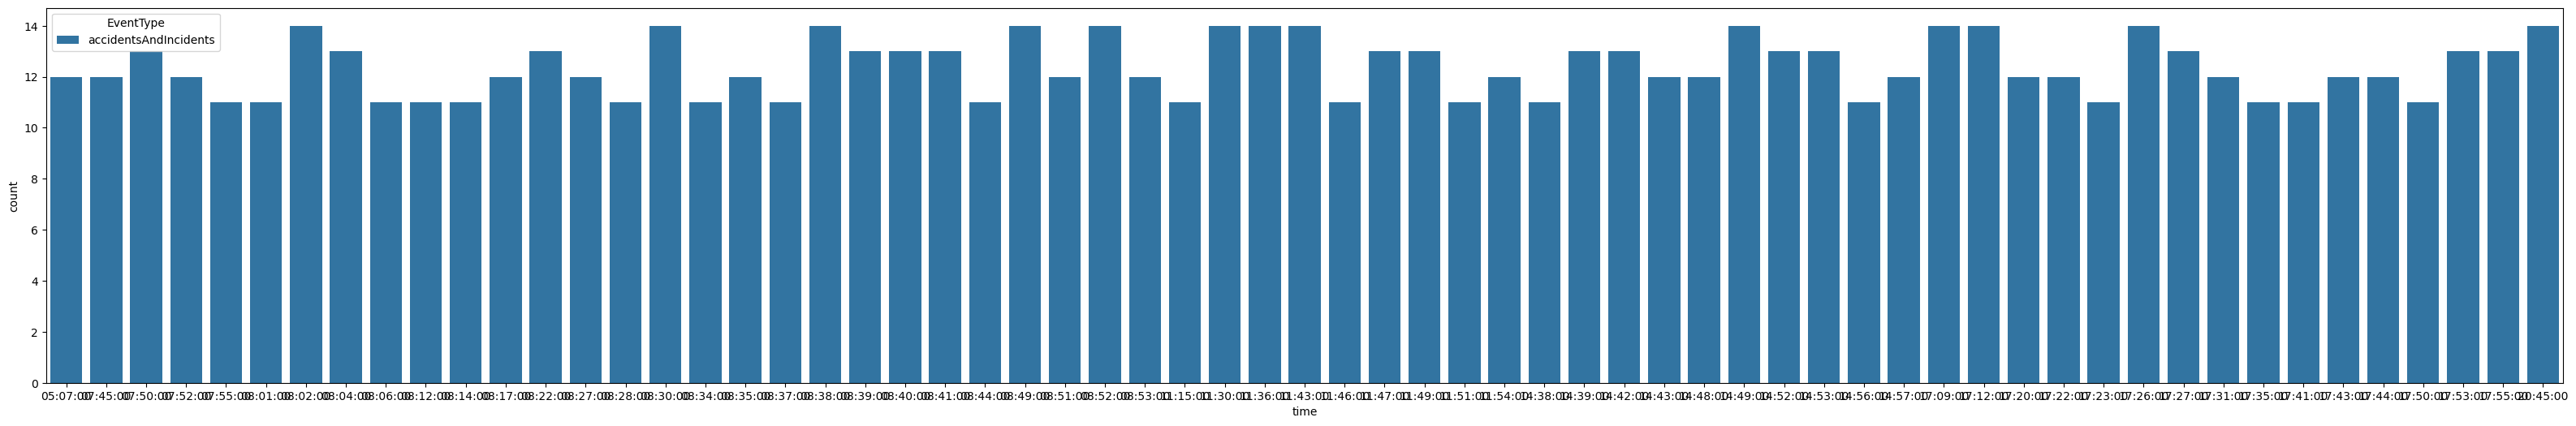

In [136]:
reportedDT = pd.to_datetime(dfImputed['LocalReported'])
by_hour = reportedDT.dt.hour.value_counts().sort_index()


by_time = reportedDT.dt.time.value_counts()


df_time_binned = dfImputed.loc[reportedDT.dt.time.isin(by_time.loc[(by_time > 10) & (by_time <15)].index.to_list()), ['EventType', 'LocalReported']]

df_time_binned['time'] = pd.to_datetime(df_time_binned['LocalReported']).dt.time
df_time_binned = df_time_binned.sort_values('time')

fig, ax = plt.subplots(figsize=(40, 6))

sns.countplot(df_time_binned, x='time', hue='EventType', ax=ax, stat='count')
plt.show()